In [12]:
import math
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

# equations
def parabula(x):
    return x[0]**2 - x[1]

def linear(x):
    return x[0] - x[1]


# mutation

def mutation(generation, features, feature_range, number_of_mutations, vis_key = False):
    # if we want visualise make new array for visualise
    if vis_key == True:
        features_for_vis = copy.deepcopy(features)
    # take id of mutants
    mutants = random.sample(generation, number_of_mutations)
    # add new mutant skill
    for mutant_id in mutants:
        # where to change
        skill_id = random.sample(range(len(features[mutant_id])), 1)[0]
        # what to change
        new_skill = random.sample(feature_range, 1)
        if vis_key == True:
            features_for_vis[mutant_id][skill_id] = new_skill
        features[mutant_id][skill_id] = new_skill[0]
    if vis_key == True:
        return features, features_for_vis
    return features

# reproduction

# sigmoid to make + prob bigger
def sigmoid_plus(x):
    try:
        #math domain error fix
        shift = 1
        #---------------------
        x = math.log10(x + shift) if x > 0 else -math.log10(abs(x) + shift)
        result = 1 / (1 + math.exp(x))
    except OverflowError:
        result = 0
    return result

# sigmoid to make - prob bigger
def sigmoid_minus(x, std, sensivity):
    try:
        # add sensivity
        ## add normalize [-1*sensisity : 1*sensisity]
        x = (x / std) * sensivity
        result = 1 / (1 + math.exp(-x))
    except OverflowError:
        if x > 0:
            result = 1
        if x < 1:
            result = 0
    return result

def count_probs_to_take_feature(generation, sensivity, find_max):
    # alpha to except division by 0 
    alpha = 0.000000000000000000001
    max_result = abs(np.max(generation))
    min_result = abs(np.min(generation))
    if min_result > 0:
        std = max_result
    elif max_result < 0:
        std = abs(min_result)
    else:
        std = max_result + min_result
    #print('std', std)
    if find_max == True:
        coefficient_to_survive = list(map(lambda i: 1 / (sigmoid_plus(i) + alpha), generation))
    else:
        coefficient_to_survive = list(map(lambda i: (1 / (sigmoid_minus(i, std, sensivity) + alpha)), generation))
        #print('coefficient_to_survive', coefficient_to_survive)
    sum_of_probs_to_survive = np.sum(coefficient_to_survive)
    # make prob to be taken
    probs = list(map(lambda i: i / sum_of_probs_to_survive, coefficient_to_survive))
    return probs


def make_child(father, mother, vis_key):
    # barrier to split features
    alpha = random.sample(range(int(len(father) + 1)), 1)[0]
    alpha = -alpha % len(father)
    # add fix of not mixing features
    first_part, _ = np.split(father, [alpha])
    _, second_part = np.split(mother, [alpha])
    if not first_part:
        child = mother
    elif not second_part:
        child = father
    else:
        child = [i for i in first_part] + [i for i in list(second_part)]
    
    #if len(child) == 1:
        #print(father, mother)
        #print(first_part, second_part)
        #print(alpha)
    return child


def reproduction(generation_results, features, num_of_children, sensivity, vis_key=False, find_max = True):
    
    # discard the same results, because they will affect to prob
    # add fix for multiple mins
    
    #features, index = np.unique(features, return_index=True, axis = 0)
    #generation_results = [generation_results[i] for i in index]
    
    #print('--------------------')
    #print('features', features)
    #print('generation_results', generation_results)
    
    new_generation_features = []
    vis_new_generation_features = []
    probs = count_probs_to_take_feature(generation_results, sensivity, find_max)
    #print('probs', probs)
    for child_id in range(num_of_children):
        # take father and mother with the best features
        father_id = np.random.choice(range(len(generation_results)), p=probs)
        mother_id = np.random.choice(range(len(generation_results)), p=probs)

        if vis_key == True:
            child, vis_child = make_child(features[father_id], features[mother_id], vis_key)
            vis_new_generation_features.append(vis_child)
        else:
            child = make_child(features[father_id], features[mother_id], vis_key)
        new_generation_features.append(child)
    if vis_key == True:
        return new_generation_features, vis_new_generation_features
    return new_generation_features

# evaluate

def evaluate(features, function):
    generation_results = []
    for feature in features:
        generation_results.append(function(feature))
    return generation_results

# run genetic algorithm

def run_genetic_algorithm(features, function, feature_range, num_of_children, speed_parameter, year, find_max, sensivity = 1):
    generation_results = evaluate(features, function)
    generation_ids = range(len(generation_results))
    if year % speed_parameter == 0:
        # make mutation
        number_of_mutations = random.sample(range(int(len(generation_results) / 10 + 1)), 1)[0]
        features = mutation(generation_ids, copy.deepcopy(features), feature_range, number_of_mutations)
        generation_results = evaluate(features, function)
    # get new features
    features = reproduction(generation_results, features, num_of_children, sensivity = sensivity,find_max = find_max)
    return features

def run_genetic_algorithm_with_smart_mutation(features, old_generation_results, function, feature_range, num_of_children, speed_parameter, year, find_max, sensivity = 1):
    generation_results = evaluate(features, function)
    generation_ids = range(len(generation_results))
    #print('-isclose-',np.mean(generation_results), np.mean(old_generation_results), np.isclose(np.mean(generation_results), np.mean(old_generation_results)))
    if np.isclose(np.mean(generation_results), np.mean(old_generation_results)):
        # make mutation
        number_of_mutations = random.sample(range(int(len(generation_results) / 10 + 1)), 1)[0]
        features = mutation(generation_ids, copy.deepcopy(features), feature_range, number_of_mutations)
        generation_results = evaluate(features, function)
    # get new features
    new_features = reproduction(generation_results, features, num_of_children, sensivity = sensivity,find_max = find_max)
    return new_features, features

# plot history

def plot(History):
    fig = plt.figure()

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    ax.set_xlabel('year')
    ax.set_ylabel('value')

    # Create a legend for the first line.
    line1, = plt.plot(range(len(History)), History, label="agent", linestyle='--')

    first_legend = plt.legend(handles=[line1], loc=1)
    # Add the legend manually to the current Axes.
    ax = plt.gca().add_artist(first_legend)
    plt.show()

In [13]:

def find_max(features, function, life_time, feature_range, num_of_children, speed_parameter):
    init_results = np.average(evaluate(features, function))
    print(evaluate(features, function))
    print('init results: ', init_results)
    History = []

    find_max = True
    for year in range(life_time):
        # print(year)
        features = run_genetic_algorithm(features, function, feature_range, num_of_children, speed_parameter, year, find_max)
        old_generation_results = evaluate(features, function)
        result = np.average(old_generation_results)
        History.append(result)

    print('done!')
    print('final result', np.average(old_generation_results))

    plot(History)


def find_min(old_features, function, life_time, feature_range, num_of_children, speed_parameter, sensivity, smart_mutation = False):
    new_features = copy.deepcopy(old_features)
    print(old_features)
    init_results = np.average(evaluate(old_features, function))
    old_generation_results = init_results
    print(evaluate(old_features, function))
    print('init results: ', init_results)
    History = []
    
    find_max = False
    for year in range(life_time):
        # print(year)
        
        if smart_mutation == True:
            new_features, old_features = run_genetic_algorithm_with_smart_mutation(new_features, old_generation_results, function, feature_range, num_of_children, speed_parameter, year, sensivity = sensivity, find_max = find_max)
        else:
            old_features = run_genetic_algorithm(old_features, function, feature_range, num_of_children, speed_parameter, year, sensivity = sensivity, find_max = find_max)
        #print(old_generation_results)
        old_generation_results = evaluate(old_features, function)
        #print(old_generation_results, np.average(old_generation_results))
        result = np.average(old_generation_results)
        History.append(result)

    print('done!')
    print('final result', np.average(old_generation_results))
    #print(old_features)
    plot(History)
    return new_features

[[10, 4], [14, 21], [10, 1], [14, 10], [10, 40]]
[96, 175, 99, 186, 60]
init results:  123.2


/home/artem/anaconda3/envs/pixor_tmp/lib/python3.6/site-packages/ipykernel_launcher.py:94: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


done!
final result -39.0


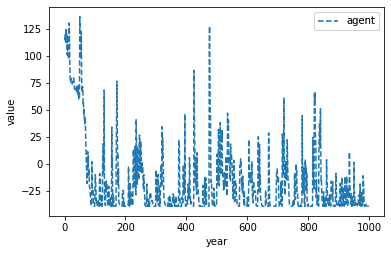

[[10, 4], [14, 21], [10, 1], [14, 10], [10, 40]]

In [14]:
features = [[10, 4], [14, 21], [10, 1], [14, 10], [10, 40]]
function = parabula
life_time = 1000

feature_range = range(-40, 40)
num_of_children = 100
speed_parameter = 5
sensivity = 1

find_min(features, function, life_time, feature_range, num_of_children, speed_parameter, sensivity)

[96, 175, 99, 186, 60]
init results:  123.2


/home/artem/anaconda3/envs/pixor_tmp/lib/python3.6/site-packages/ipykernel_launcher.py:94: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


done!
final result 1599.55


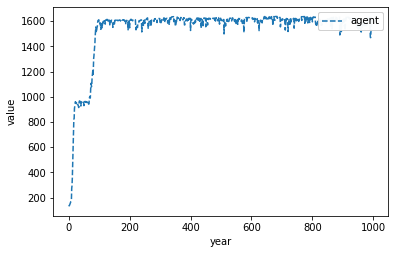

In [15]:
find_max(features, function, life_time, feature_range, num_of_children, speed_parameter)

In [9]:
def ackley(x, a=20, b=0.2, c=2*np.pi):
    """
    x: vector of input values
    """
    d = len(x) # dimension of input vector x
    x = np.array(x)
    sum_sq_term = -a * np.exp(-b * np.sqrt(sum(x*x) / d))
    cos_term = -np.exp(sum(np.cos(c*x) / d))
    return (a + np.exp(1) + sum_sq_term + cos_term)


[[10, 4], [14, 21], [10, 1], [14, 10], [10, 40]]
[15.63953958140311, 19.43649630368633, 15.171841011518413, 18.2447219780535, 19.941294368588597]
init results:  17.68677864864999


/home/artem/anaconda3/envs/pixor_tmp/lib/python3.6/site-packages/ipykernel_launcher.py:94: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


done!
final result 3.6253849384403605


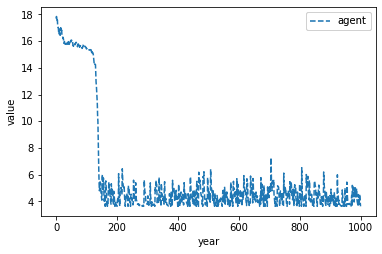

[[1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1]]

In [10]:
features = [[10, 4], [14, 21], [10, 1], [14, 10], [10, 40]]
function = ackley
life_time = 1000

feature_range = range(-40, 40)
num_of_children = 100
smart_mutation = True
#speed_parameter = 10000
sensivity = 1

find_min(features, function, life_time, feature_range, num_of_children, speed_parameter, sensivity, smart_mutation)